# 4-Body Problem (Errebersiblea)

<ul id="top">
<li><a href="#Loading-packages-and-functions"> 
             Loading packages and functions</a></li>
    
<li><a href="#Definition-of-the-N-body-problem"> 
             Definition of the N-body problem</a></li>  

<li><a href="#IRKGL16-Integration">
             IRKGL16-Integration</a></li>

<li><a href="#Integration-with-NEW-adaptive-stepsize">
             Integration with NEW-adaptive stepsize</a></li>
    
<li><a href="#Integration-Time-Renormalization">
             Integration-Time-Renormalization</a></li>
             
<li><a href="#Comparison">
               Comparison</a></li>

</ul> 


## Loading packages and functions

In [1]:
using LinearAlgebra
using Plots,  LaTeXStrings
using DataFrames
using OrdinaryDiffEq
using IRKGaussLegendre

In [2]:
PATH_DATA="./Data/"

PATH_SRC="../../src/simd/"
include(string(PATH_SRC,"IRKGL_SIMD.jl"))
using .IRKGL_SIMD   

PATH_SRC="../../src/simd-new/"
include(string(PATH_SRC,"IRKGL_SIMD_NEW.jl"))
using .IRKGL_SIMD_NEW   

PATH_SRC="../../src/seq/"
include(string(PATH_SRC,"IRKGL_SEQ.jl"))
using .IRKGL_SEQ 

setprecision(BigFloat, 256)

##### <a href="#top">Back to the top</a>

## Definition of the N-body problem

In [3]:
PATH_ODES="../../ODEProblems/"

include(string(PATH_ODES,"Initial4Body.jl"))
include(string(PATH_ODES,"Nbody.jl"));

### Initial value problem: 4-body problem 


In [4]:
u0, Gm, bodylist = Initial4Body(Float64)
u0_B, Gm_B, bodylist = Initial4Body(BigFloat)

q0=u0[:,:,1]
v0=u0[:,:,2]
dim=length(size(u0))

N = length(Gm)

show(bodylist)
E0=NbodyEnergy(u0,Gm)

["body1" "body2" "body3" "body4"]

-0.009155768125361017591573604991962832295417474561403274954000151196222307722926314

In [5]:
# Testing: center of mass of the system at the origin of coordinates with zero velocity

q0_ = zeros(3)
v0_ = zeros(3)
Gm0_ = 0.
for i in 1:N
    Gmi = Gm[i]
    qi = u0[:,i,1]
    vi = u0[:,i,2]
    q0_ += Gmi*qi
    v0_ += Gmi*vi
    Gm0_ += Gmi
end
(norm(q0_/Gm0_), norm(v0_/Gm0_))

(9.962514728810559707395523567277471789590727484892810592201122592921655551255422e-19, 6.845627627315894680875114479835484797703780132975955619801544902061530283499127e-19)

In [6]:
# Egoera aldagai bat gehitu dut: tau edo t integrazioan kalkulatzeko
u0R=fill(zero(eltype(u0_B)),(3,N+1,2))
u0R[1:3,1:N,1:2].=u0_B[:,:,:];

In [7]:
t0=0.
tF=2.

tspan= (t0,tF)
dim=length(size(u0))


tspan_B= (BigFloat(t0),BigFloat(tF))
prob1 = ODEProblem(NbodyODE!, u0R,tspan_B, Gm_B)
prob2 = ODEProblem(NbodyODEer2!, u0R,tspan_B, Gm_B);

 <a href="#top">Back to the top</a>

## IRKGL16-Integration

In [32]:
tol = 1e-18
sol1=solve(prob1,IRKGL16(initial_interp=false), adaptive=true, 
    maxiters = 1000, dt = 0.2, reltol=tol, abstol=tol)

steps=sol1.t[2:end]-sol1.t[1:end-1]
nsteps=length(steps)

@show sol1.retcode, nsteps

[sol1.stats.nf sol1.stats.naccept]

(sol1.retcode, nsteps) = (SciMLBase.ReturnCode.Success, 120)


1×2 Matrix{Int64}:
 42795  120

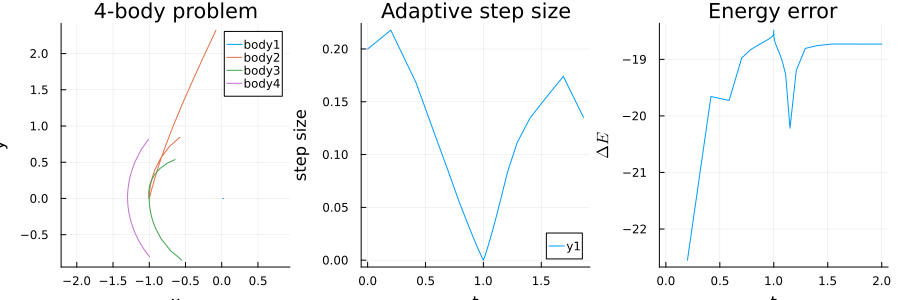

In [19]:
pl = plot(title="4-body problem", 
            xlabel="x", ylabel="y",  aspect_ratio=1)

for j = 1:N
    x  = [u[1,j,1] for u in sol1.u]
    y  = [u[2,j,1] for u in sol1.u] 
    pl = plot!(x,y, label=bodylist[j]) 
end 

pl2=plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps =sol1.t[2:end]-sol1.t[1:end-1]
pl2=plot!(sol1.t[1:end-1],steps)

#u0Big=BigFloat.(prob1.u0)
#GmBig=BigFloat.(prob1.p)

E0=NbodyEnergy(u0_B, Gm_B)
ΔE1 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol1.u)./E0.-1
pl3=plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
pl3=plot!(sol1.t,log10.(abs.(ΔE1)), label="")

plot(pl,pl2, pl3, layout=(1,3), size=(900,300))

 <a href="#top">Back to the top</a>

## Integration with NEW-adaptive stepsize

In [35]:
m=1
alg=IRKGL_seq(m=m, initial_extrap=0, Dtau=0.58)

sol2=solve(prob2,alg, adaptive=true, maxiters=1000)

steps=sol2.t[2:end]-sol2.t[1:end-1]
nsteps=length(steps)



@show sol2.retcode,nsteps, sol2.u[end][1,N+1,1]

[sol2.stats.nf sol2.stats.naccept]

(sol2.retcode, nsteps, (sol2.u[end])[1, N + 1, 1]) = (SciMLBase.ReturnCode.Success, 129, 74.47634983366104003448551804317326809983038587008502147317238428386645436880562)


1×2 Matrix{Int64}:
 73592  129

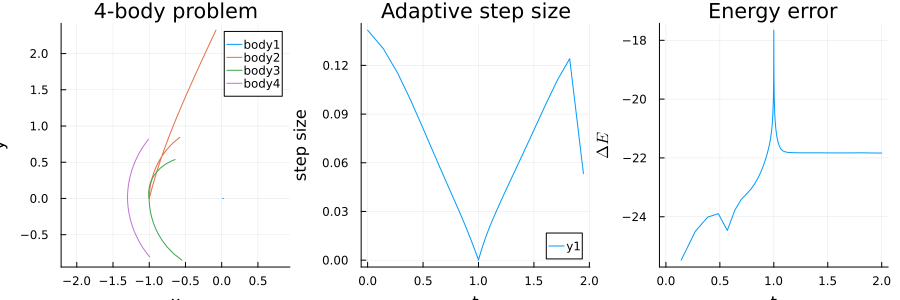

In [20]:
pl = plot(title="4-body problem", 
            xlabel="x", ylabel="y",  aspect_ratio=1)

for j = 1:N
    x  = [u[1,j,1] for u in sol2.u]
    y  = [u[2,j,1] for u in sol2.u] 
    pl = plot!(x,y, label=bodylist[j]) 
end 

pl2=plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps =sol2.t[2:end]-sol2.t[1:end-1]
pl2=plot!(sol2.t[1:end-1],steps)

#u0Big=BigFloat.(prob2.u0)
#GmBig=BigFloat.(prob2.p)

E0=NbodyEnergy(u0_B, Gm_B)
ΔE2 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol2.u)./E0.-1
pl3=plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
pl3=plot!(sol2.t,log10.(abs.(ΔE2)), label="")

plot(pl,pl2, pl3, layout=(1,3), size=(900,300))

 <a href="#top">Back to the top</a>

## Integration-Time-Renormalization

In [12]:
tau0=0.
TauF=sol2.u[end][1,N+1,1]
tauspan_B= (BigFloat(tau0),BigFloat(TauF))
prob3 = ODEProblem(NbodyODERen!, u0R,tauspan_B, Gm_B);

In [13]:
m=1
alg=IRKGL_seq(m=m, initial_extrap=0)

sol3=solve(prob3,alg, dt=BigFloat(0.58), adaptive=false, maxiters=1000)

steps=sol3.t[2:end]-sol3.t[1:end-1]
nsteps=length(steps)

tR=[u[1,N+1,1] for u in sol3.u];

@show sol3.retcode,nsteps

[sol3.stats.nf sol3.stats.naccept]

(sol3.retcode, nsteps) = (SciMLBase.ReturnCode.Success, 129)


1×2 Matrix{Int64}:
 47592  129

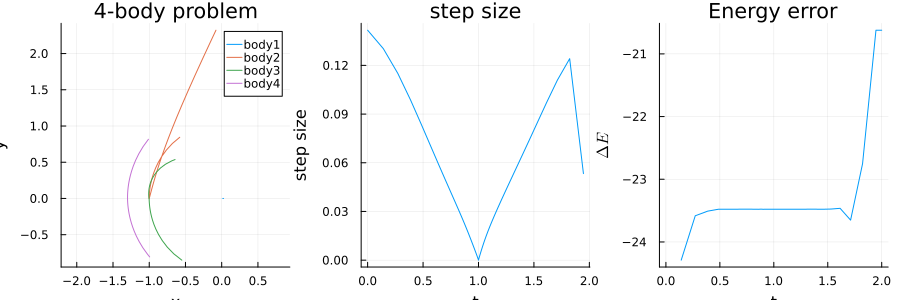

In [37]:
pl = plot(title="4-body problem", 
            xlabel="x", ylabel="y",  aspect_ratio=1)

for j = 1:N
    x  = [u[1,j,1] for u in sol3.u]
    y  = [u[2,j,1] for u in sol3.u] 
    pl = plot!(x,y, label=bodylist[j]) 
end 

pl2=plot(xlabel="t", ylabel="step size",title="step size")
steps =tR[2:end]-tR[1:end-1]
pl2=plot!(tR[1:end-1],steps, label="")


#u0Big=BigFloat.(prob3.u0)
#GmBig=BigFloat.(prob3.p)

E0=NbodyEnergy(u0_B, Gm_B)
ΔE3 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol3.u)./E0.-1
pl3=plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
pl3=plot!(tR,log10.(abs.(ΔE3)), label="")

plot(pl,pl2, pl3, layout=(1,3), size=(900,300))

 <a href="#top">Back to the top</a>

## Comparison

### Energy error

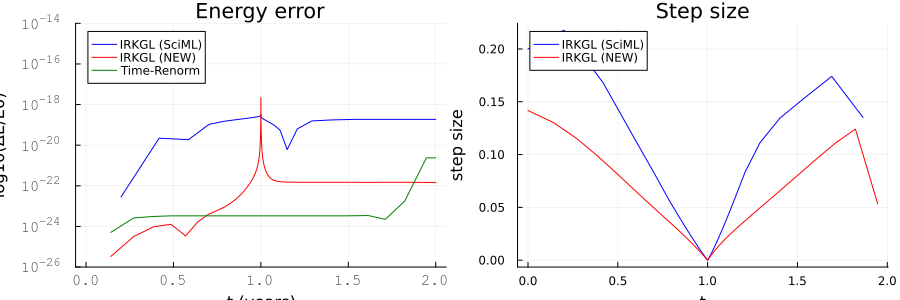

In [39]:
E0=NbodyEnergy(u0_B, Gm_B)
yrange=(1e-26,1e-14)
ΔE1 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol1.u)./E0.-1
ΔE2 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol2.u)./E0.-1
ΔE3 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol3.u)./E0.-1

pl1=plot(title="Energy error", xlabel="t (years)", ylabel="log10(ΔE/E0)", 
     yscale=:log10, ylims=yrange,
     xtickfont = font(8, "Courier"),
     ytickfont = font(8, "Courier"),
     legend=:topleft)

pl1=plot!(sol1.t,abs.(ΔE1),label="IRKGL (SciML)", color="blue")
pl1=plot!(sol2.t,abs.(ΔE2),label="IRKGL (NEW)", color="red")
pl1=plot!(tR,abs.(ΔE3), label="Time-Renorm", color="green")

pl2=plot(xlabel="t", ylabel="step size",title="Step size",legend=:topleft)
steps1 =sol1.t[2:end]-sol1.t[1:end-1]
pl2=plot!(sol1.t[1:end-1],steps1,label="IRKGL (SciML)", color="blue")
steps2 =sol2.t[2:end]-sol2.t[1:end-1]
pl2=plot!(sol2.t[1:end-1],steps2,label="IRKGL (NEW)", color="red")
steps3 =tR[2:end]-tR[1:end-1]
pl3=plot!(tR[1:end-1],steps3,label="Time-Renorm", color="green")

plot(pl1,pl2, layout=(1,2), size=(900,300))


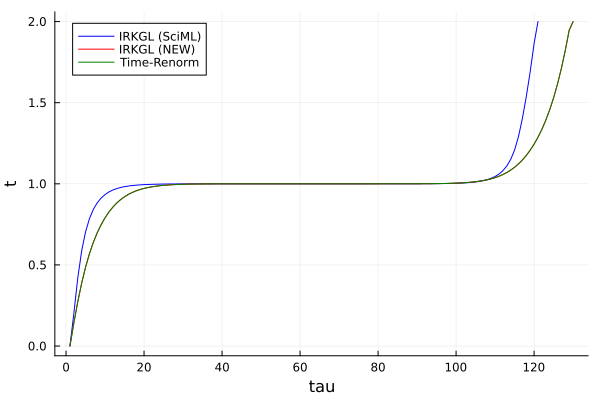

In [29]:
# t-ren taurekiko eboluzioa aztertzeko grafikoa
# ( kontutan hartuta, tau urrats kopuruaren proportzionala dela)
plot(sol1.t, xlabel="tau", ylabel="t", label="IRKGL (SciML)", color="blue")
plot!(sol2.t, label="IRKGL (NEW)", color="red")
plot!(tR, label="Time-Renorm", color="green")

### Summary

In [30]:
summary=DataFrame()
summary.Steps_SciML=[sol1.stats.naccept]
summary.Steps_New=[sol2.stats.naccept]
summary.Steps_Reg=[sol3.stats.naccept]
summary.it_SciML=[sol1.stats.nf/sol1.stats.naccept/8]
summary.it_New=[sol2.stats.nf/sol2.stats.naccept/8]
summary.it_Reg=[sol3.stats.nf/sol3.stats.naccept/8]
show(summary)

1×6 DataFrame
 Row │ Steps_SciML  Steps_New  Steps_Reg  it_SciML  it_New   it_Reg  
     │ Int64        Int64      Int64      Float64   Float64  Float64 
─────┼───────────────────────────────────────────────────────────────
   1 │         120        129        129   44.5781  71.3101  46.1163